# pvlib-Python Forecasting (Denver, CO)
### Install Standard Release 

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2


# Try to save Excel
!pip install openpyxl

In [5]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 39.7, -105.2, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.fromordinal(737548), tz=tz)
end = start + pd.Timedelta(days=6)
irrad_vars = ['ghi','dni','dhi']

In [6]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [7]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

In [14]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Wind_speed_gust_surface  \
2020-05-03 06:00:00-06:00                 1.419329   
2020-05-03 09:00:00-06:00                 2.769763   
2020-05-03 12:00:00-06:00                 2.862701   
2020-05-03 15:00:00-06:00                 3.700000   
2020-05-03 18:00:00-06:00                 4.010972   

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2020-05-03 06:00:00-06:00                                                0.0                
2020-05-03 09:00:00-06:00                                                3.0                
2020-05-03 12:00:00-06:00                                                1.0                
2020-05-03 15:00:00-06:00                                                0.0                
2020-05-03 18:00:00-06:00                                                0.0                

                           Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average  \
2020-05-03 06:00:00

### Process Data with pvlib

In [15]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-03 06:00:00-06:00   7.750000    1.212621    0.001957    0.000000   
2020-05-03 09:00:00-06:00   6.782135    2.774024  481.671212  628.029321   
2020-05-03 12:00:00-06:00   5.108978    2.908560  873.921903  687.067111   
2020-05-03 15:00:00-06:00  18.508942    2.420950  788.381032  712.077950   
2020-05-03 18:00:00-06:00  28.966064    4.337219  278.875899  499.039500   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-03 06:00:00-06:00    0.001957          28.0        11.0        24.0   
2020-05-03 09:00:00-06:00  135.128579           3.0         3.0         0.0   
2020-05-03 12:00:00-06:00  260.952784           1.0         1.0         0.0   
2020-05-03 15:00:00-06:00  209.679897           0.0         0.0         0.0   
2020-05-03 18:00:00-06:00   99.049739           0.0         0.0         0.0   

                           high_clouds  
2020-05-03 06:00:00-06:00  

### GFS'S Class

In [16]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-03 06:00:00-06:00   7.750000    1.212621    0.001957    0.000000   
2020-05-03 09:00:00-06:00   6.782135    2.774024  481.671212  628.029321   
2020-05-03 12:00:00-06:00   5.108978    2.908560  873.921903  687.067111   
2020-05-03 15:00:00-06:00  18.508942    2.420950  788.381032  712.077950   
2020-05-03 18:00:00-06:00  28.966064    4.337219  278.875899  499.039500   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-03 06:00:00-06:00    0.001957          28.0        11.0        24.0   
2020-05-03 09:00:00-06:00  135.128579           3.0         3.0         0.0   
2020-05-03 12:00:00-06:00  260.952784           1.0         1.0         0.0   
2020-05-03 15:00:00-06:00  209.679897           0.0         0.0         0.0   
2020-05-03 18:00:00-06:00   99.049739           0.0         0.0         0.0   

                           high_clouds  
2020-05-03 06:00:00-06:00  

## Cloud Cover & Radiation

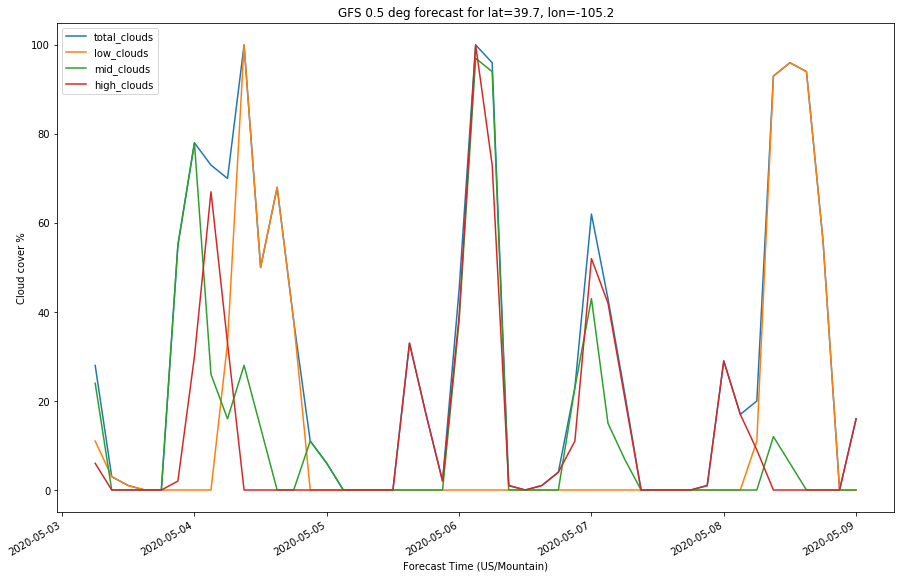

In [17]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

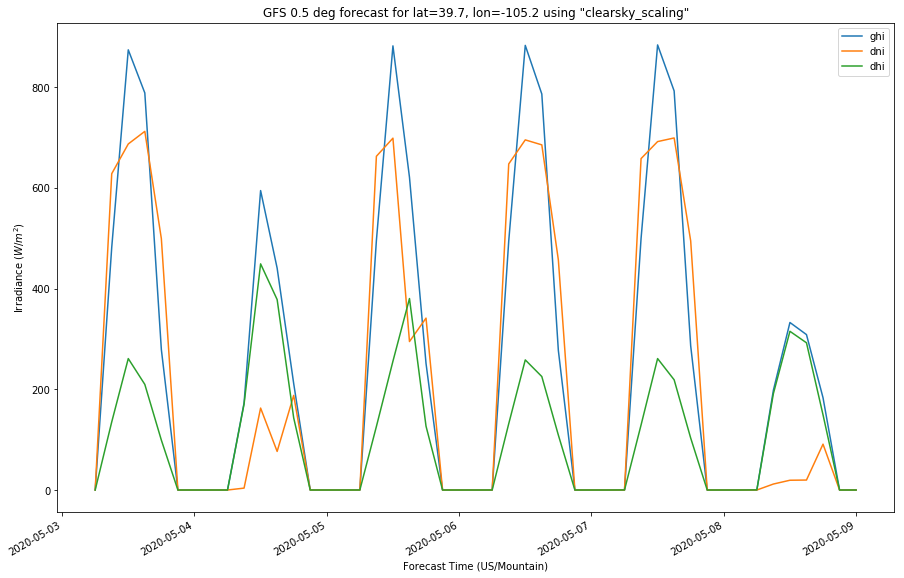

In [18]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

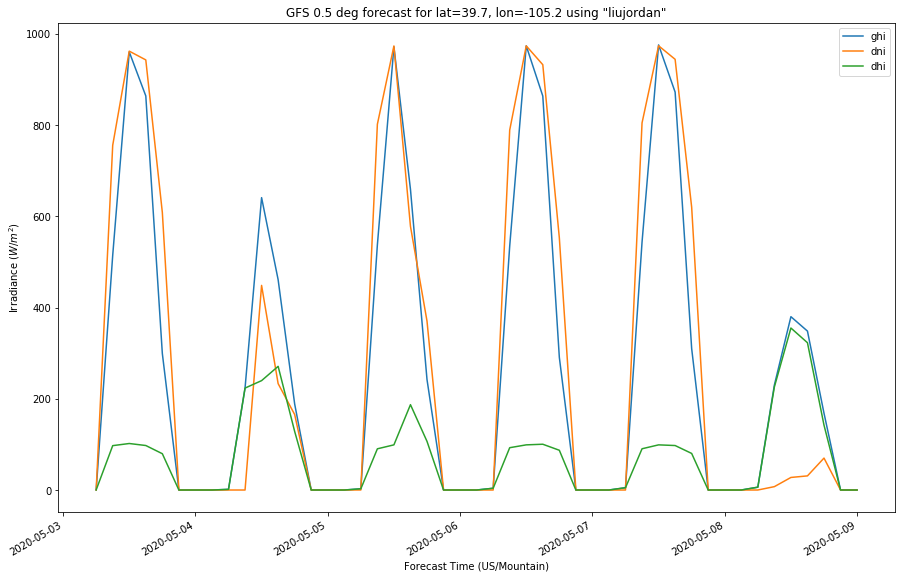

In [21]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

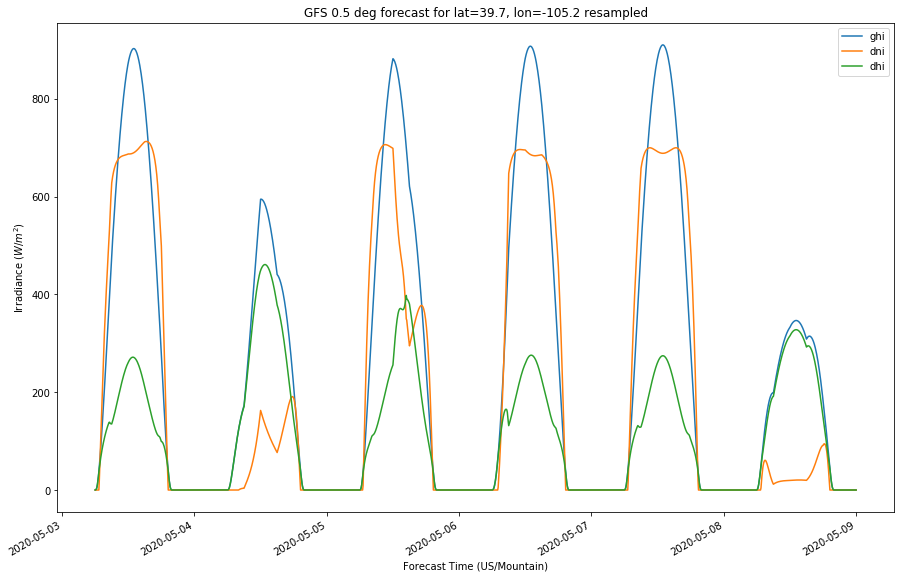

In [22]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

## Weather Models
### GFS
- The Global Forecast System is the US model that provides forecast for the entire globe (6hr update)
### HRRR

In [24]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

TypeError: Empty 'DataFrame': no numeric data to plot

### RAP

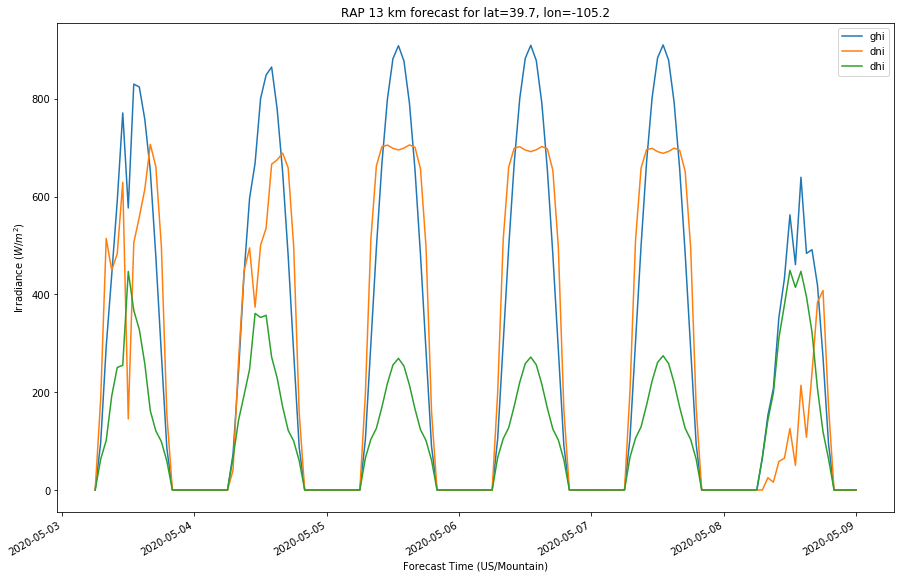

In [38]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

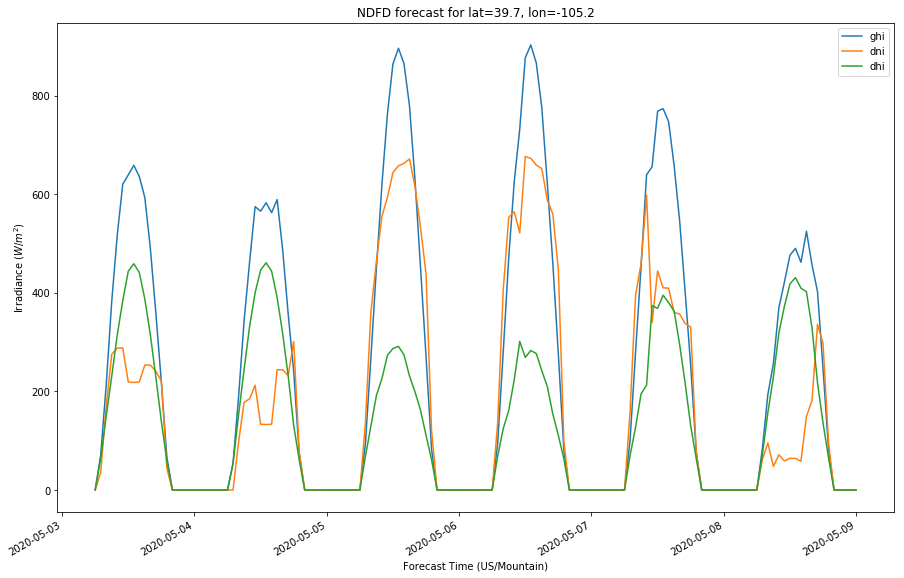

In [37]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

# PV Power Forecast

In [26]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## ModelChain Attributes

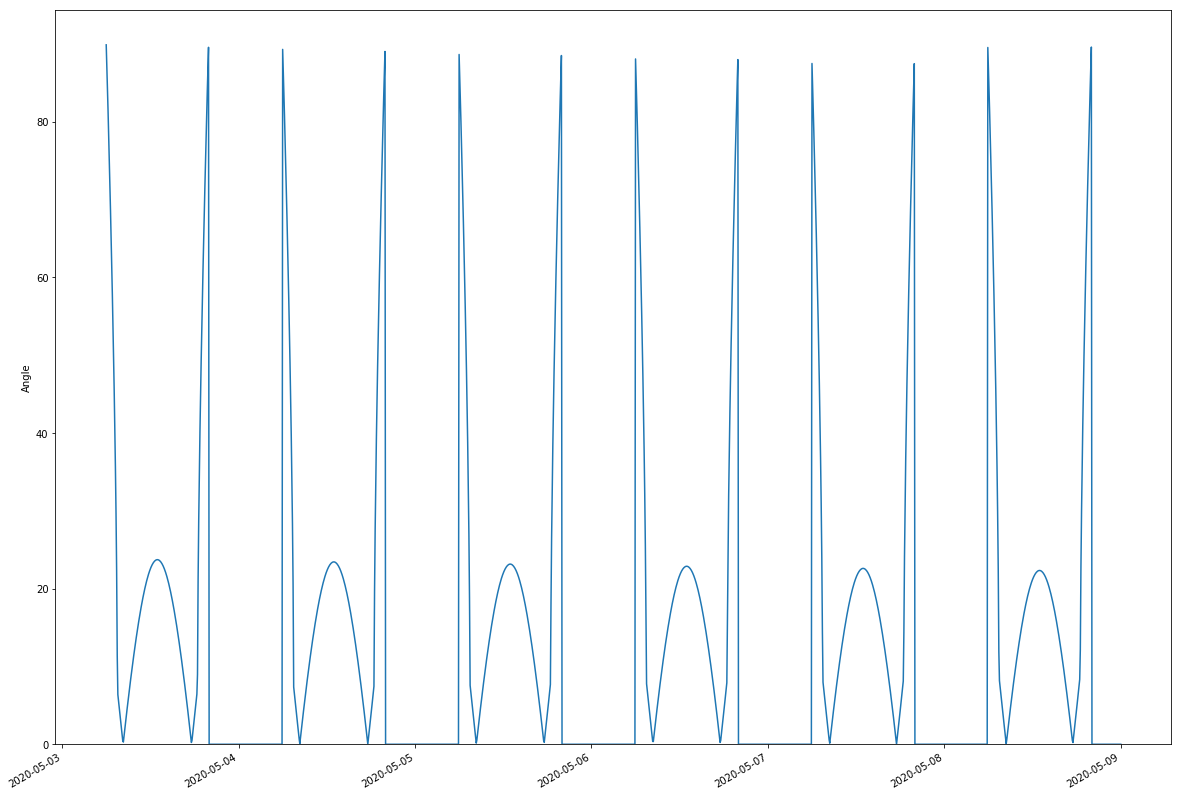

In [27]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

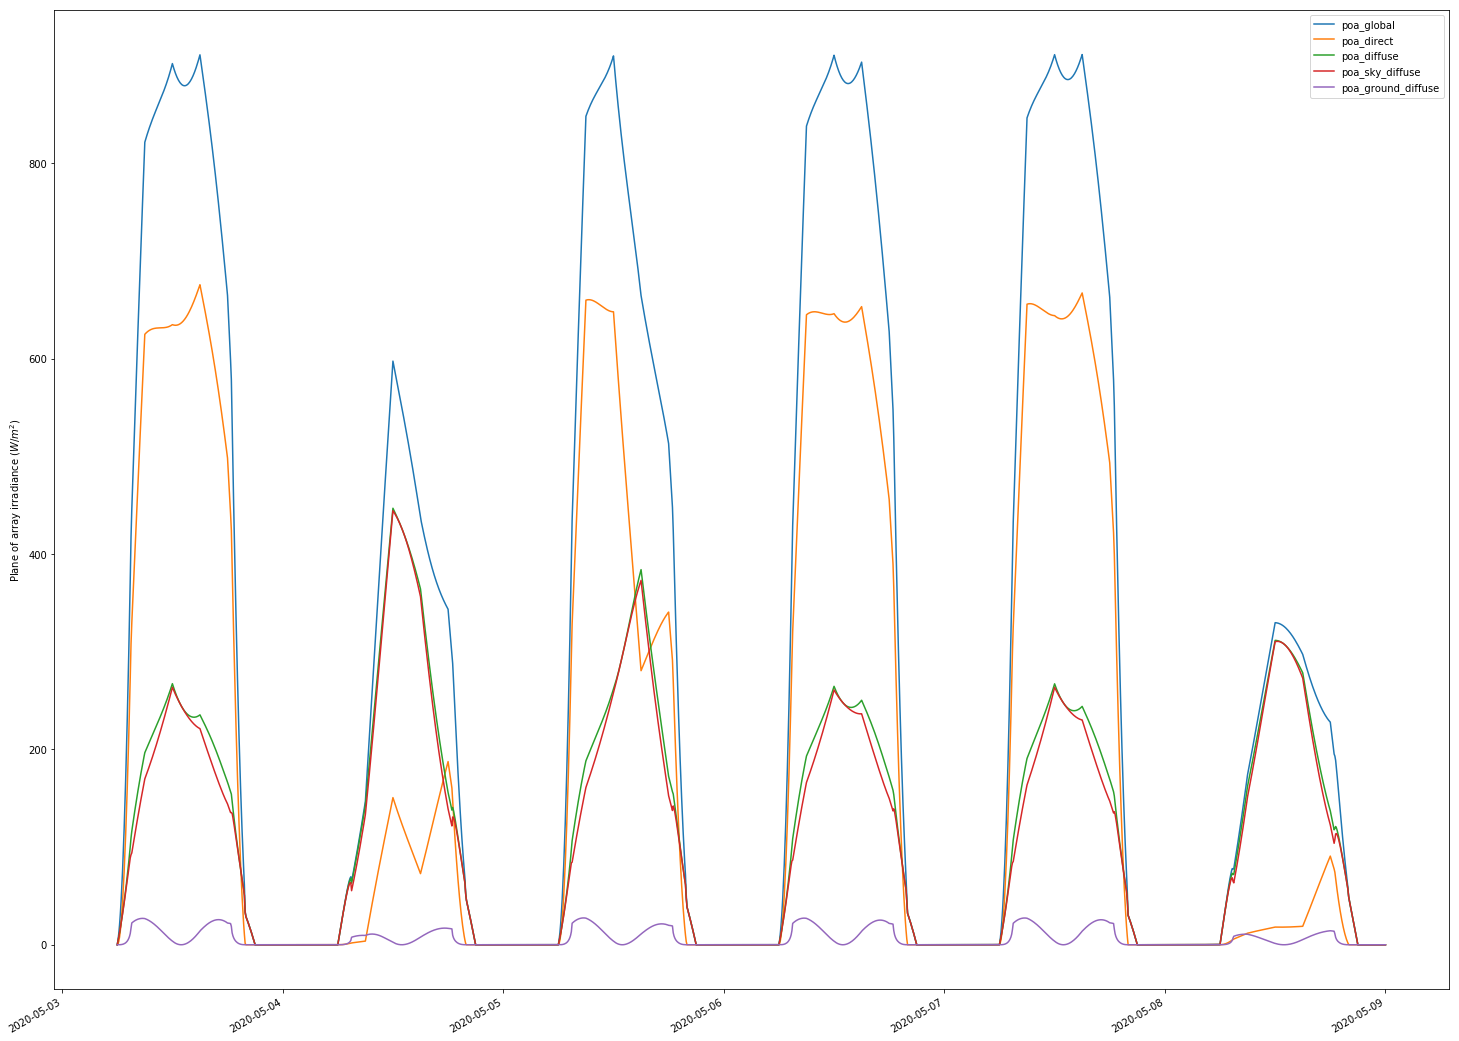

In [28]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

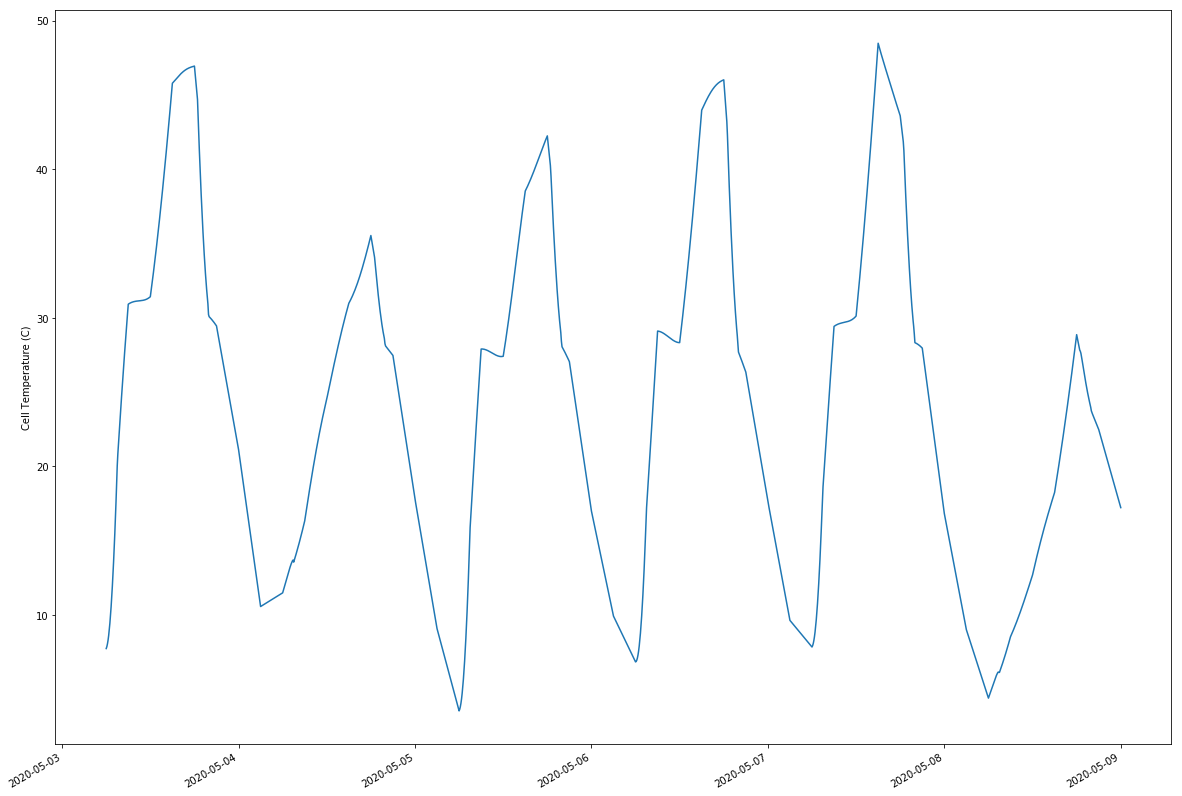

In [29]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

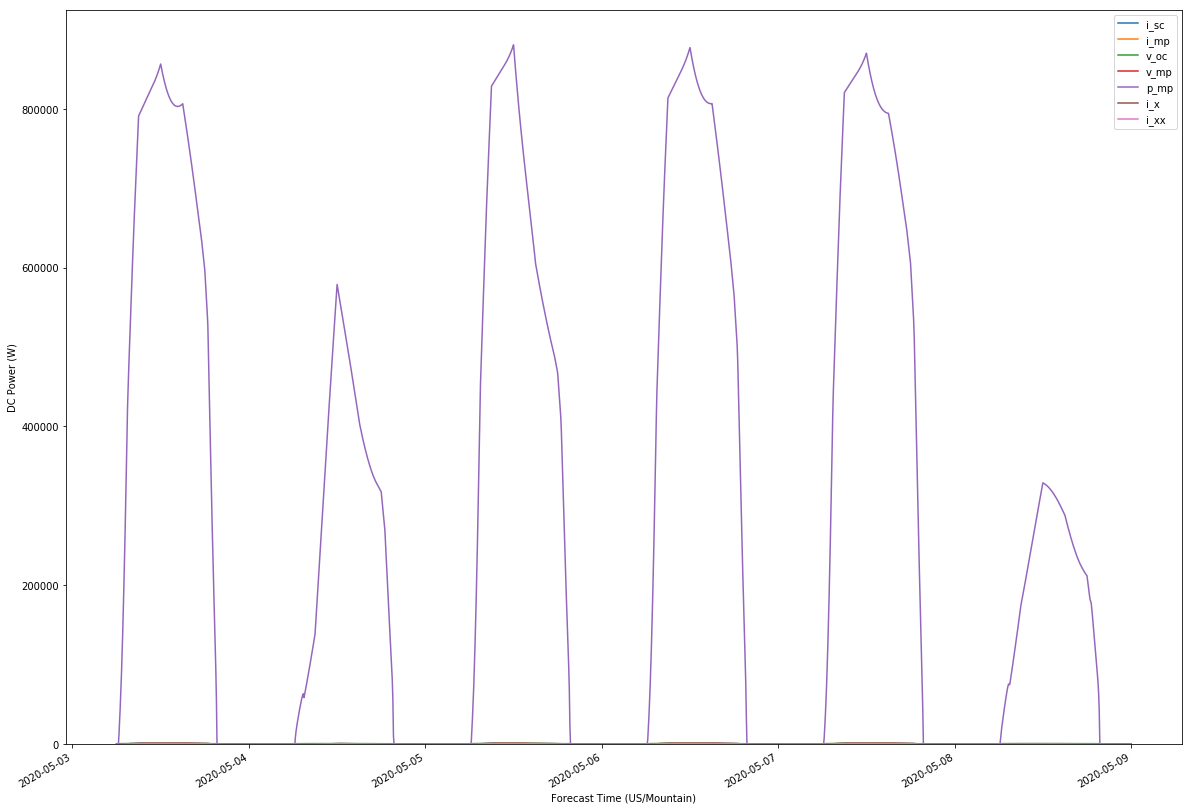

In [30]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [31]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,806.275915,721.496676,799.707135,652.924272,494399.780902,787.212341,528.010697
std,470.803140,419.295988,166.018628,139.396237,288299.146880,460.122141,295.875200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,385.213677,347.644817,805.413360,649.629428,242245.276631,375.500315,269.221102
50%,852.780036,764.989091,834.614915,683.560191,523237.940382,832.183292,570.632420
75%,1307.782464,1168.289075,862.415977,709.995617,798922.814167,1277.520789,837.398061
max,1394.623873,1241.050142,878.605409,738.883171,880371.094376,1362.616168,886.230949


In [32]:
mc.dc.fillna(0)

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-03 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-03 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-03 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-03 06:15:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-03 06:20:00-06:00,26.459903,24.011404,743.530502,528.513266,12690.345610,25.771081,19.098041
2020-05-03 06:25:00-06:00,53.707208,48.722179,776.784768,599.776409,29222.413496,52.312414,38.670620
2020-05-03 06:30:00-06:00,81.089664,73.538983,795.321416,634.800627,46682.592752,78.988818,58.244466
2020-05-03 06:35:00-06:00,110.793561,100.440736,808.748567,657.964879,66086.476806,107.930681,79.369204
2020-05-03 06:40:00-06:00,143.710808,130.229712,819.417777,674.940765,87897.341773,140.008166,102.647337
2020-05-03 06:45:00-06:00,180.112383,163.143812,828.195669,687.858459,112219.850991,175.486850,128.228183


## MC AC Power

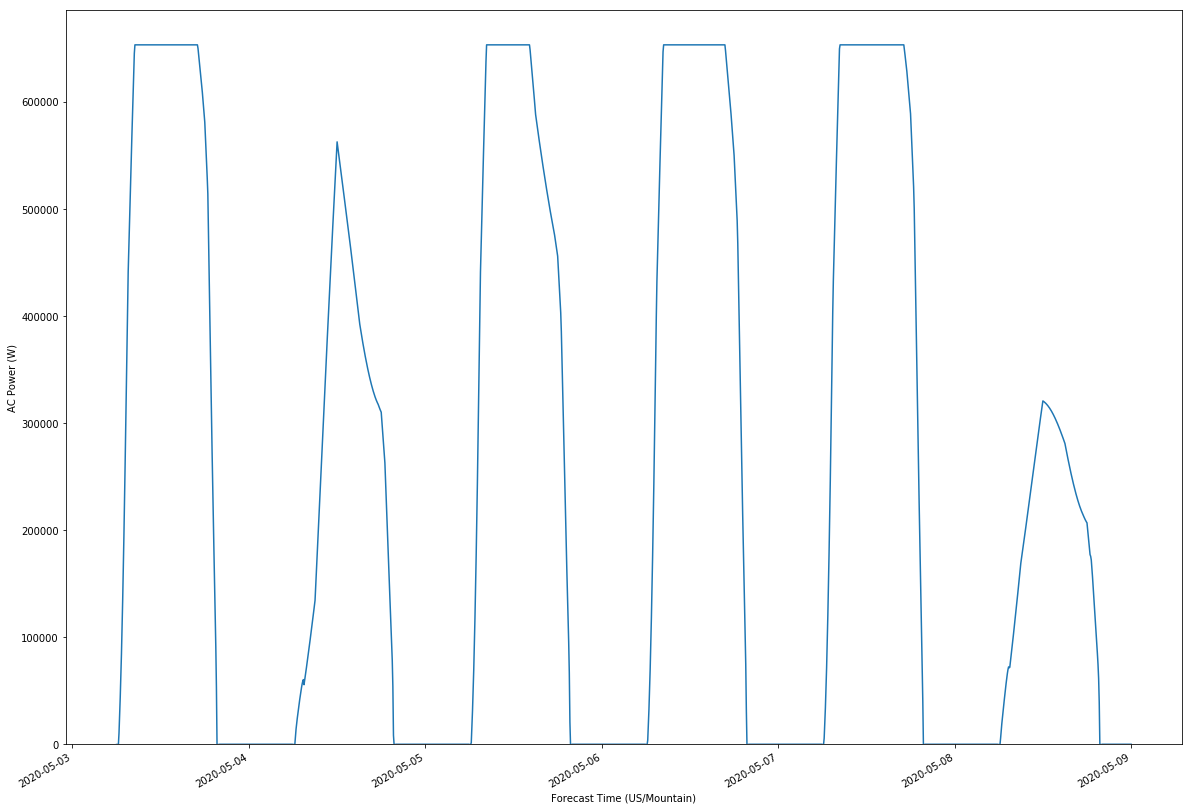

In [41]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [34]:
mc.ac.describe()

count      1010.000000
mean     432735.512624
std      229611.003913
min        -195.900000
25%      235992.573268
50%      508897.070855
75%      653000.000000
max      653000.000000
dtype: float64

In [35]:
mc.ac.fillna(0)

2020-05-03 06:00:00-06:00      -195.900000
2020-05-03 06:05:00-06:00      -195.900000
2020-05-03 06:10:00-06:00      -195.900000
2020-05-03 06:15:00-06:00      -195.900000
2020-05-03 06:20:00-06:00     10443.672775
2020-05-03 06:25:00-06:00     26515.581938
2020-05-03 06:30:00-06:00     43657.088845
2020-05-03 06:35:00-06:00     62758.532428
2020-05-03 06:40:00-06:00     84245.289489
2020-05-03 06:45:00-06:00    108201.968809
2020-05-03 06:50:00-06:00    134551.087268
2020-05-03 06:55:00-06:00    163167.436664
2020-05-03 07:00:00-06:00    193940.022734
2020-05-03 07:05:00-06:00    226794.198159
2020-05-03 07:10:00-06:00    261677.552026
2020-05-03 07:15:00-06:00    298501.717703
2020-05-03 07:20:00-06:00    337011.254863
2020-05-03 07:25:00-06:00    376498.214435
2020-05-03 07:30:00-06:00    415300.899219
2020-05-03 07:35:00-06:00    441146.255180
2020-05-03 07:40:00-06:00    462835.677857
2020-05-03 07:45:00-06:00    484242.027233
2020-05-03 07:50:00-06:00    505379.910875
2020-05-03 

# Stop Running!

In [ ]:
resampled_irrads

In [38]:
resampled_irrads.to_csv('5 min Irrad 2nd.csv', encoding='utf-8')

In [ ]:
mc.dc.fillna(0).to_csv('5 min DC 2nd.csv', encoding='utf-8')

In [ ]:
mc.ac.fillna(0).to_csv('5 min AC 2nd.csv', encoding='utf-8')